<a href="https://colab.research.google.com/github/hisunnytang/someastroml/blob/main/LightCurve_TimeSeriesModeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Copy the Cleaned Data here

In [1]:
!cp drive/MyDrive/LightCurve/a_cad6.csv .
!cp drive/MyDrive/LightCurve/a_cov_cad6.csv .

In [1]:
time_series_file = "a_cad6.csv"
cov_file         = 'a_cov_cad6.csv'

# Install the Time-Series Modelling Package

In [3]:
!git clone https://github.com/edebrouwer/gru_ode_bayes.git
%cd gru_ode_bayes/
!pip install -e .
!pip install torchdiffeq
%cd ../

Cloning into 'gru_ode_bayes'...
remote: Enumerating objects: 89, done.
remote: Total 89 (delta 0), reused 0 (delta 0), pack-reused 89
Unpacking objects: 100% (89/89), done.
/content/gru_ode_bayes
Obtaining file:///content/gru_ode_bayes
  Running setup.py develop for gru-ode-bayes


/content


In [2]:
import gru_ode_bayes
import gru_ode_bayes.data_utils as data_utils

In [3]:
pt_ds = data_utils.ODE_Dataset(csv_file= time_series_file, cov_file=cov_file)
i = 0
batch = []
for d in pt_ds:
  batch.append(d)
  i += 1
  if i > 10: break

print(d)

{'idx': 10, 'y': array([0.], dtype=float32), 'path':           Time       Value_1       Value_2  ...  Mask_3  Mask_4  Mask_5
ID                                          ...                        
10    0.600000  65504.000000  65504.000000  ...     1.0     0.0     0.0
10    3.200000     -0.406599  65504.000000  ...     0.0     0.0     0.0
10    3.300000  65504.000000  65504.000000  ...     0.0     1.0     0.0
10    5.500000  65504.000000  65504.000000  ...     0.0     1.0     0.0
10    5.600000  65504.000000     -0.465899  ...     0.0     0.0     0.0
..         ...           ...           ...  ...     ...     ...     ...
10  172.300003  65504.000000  65504.000000  ...     1.0     0.0     0.0
10  172.399994  65504.000000  65504.000000  ...     0.0     0.0     1.0
10  172.699997  65504.000000  65504.000000  ...     0.0     1.0     0.0
10  175.600006  65504.000000  65504.000000  ...     0.0     0.0     1.0
10  176.000000  65504.000000  65504.000000  ...     1.0     0.0     0.0

[145 rows 

In [4]:
d['path']

,Time,Value_1,Value_2,Value_3,Value_4,Value_5,Mask_1,Mask_2,Mask_3,Mask_4,Mask_5
ID,,,,,,,,,,,
10,0.600000,65504.000000,65504.000000,-0.465282,65504.000000,65504.000000,0.0,0.0,1.0,0.0,0.0
10,3.200000,-0.406599,65504.000000,65504.000000,65504.000000,65504.000000,1.0,0.0,0.0,0.0,0.0
10,3.300000,65504.000000,65504.000000,65504.000000,-0.377901,65504.000000,0.0,0.0,0.0,1.0,0.0
10,5.500000,65504.000000,65504.000000,65504.000000,-0.382268,65504.000000,0.0,0.0,0.0,1.0,0.0
10,5.600000,65504.000000,-0.465899,65504.000000,65504.000000,65504.000000,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
10,172.300003,65504.000000,65504.000000,-0.474490,65504.000000,65504.000000,0.0,0.0,1.0,0.0,0.0
10,172.399994,65504.000000,65504.000000,65504.000000,65504.000000,-0.377228,0.0,0.0,0.0,0.0,1.0
10,172.699997,65504.000000,65504.000000,65504.000000,-0.402567,65504.000000,0.0,0.0,0.0,1.0,0.0


In [5]:
import gru_ode_bayes.data_utils as data_utils
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import numpy as np

delta_t = 0.1
T       = 200
N = 10000
seed = 42
train_idx, val_idx = train_test_split(np.arange(N),test_size=0.2, random_state=seed)

val_options = {"T_val": 178, "max_val_samples": 1}
data_train = data_utils.ODE_Dataset(csv_file=time_series_file, 
                                    cov_file=cov_file,
                                    idx=train_idx)
data_val   = data_utils.ODE_Dataset(csv_file=time_series_file, 
                                    cov_file=cov_file,
                                    idx=val_idx, 
                                    validation = True,val_options=val_options)


dl     = DataLoader(dataset=data_train, collate_fn=data_utils.custom_collate_fn, shuffle=True, batch_size=500,num_workers=2)
dl_val = DataLoader(dataset=data_val, collate_fn=data_utils.custom_collate_fn, shuffle=False, batch_size=len(data_val),num_workers=1)

In [6]:
import tqdm.notebook as tqdm
import torch

In [7]:
for i, b in tqdm.tqdm(enumerate(dl)):
  times    = b["times"]
  time_ptr = b["time_ptr"]
  X        = b["X"] #.to(device)
  M        = b["M"] #.to(device)
  obs_idx  = b["obs_idx"]
  cov      = b["cov"] #.to(device)
  break

In [8]:
cov.shape

torch.Size([500, 5])

In [9]:
times.dtype, time_ptr.dtype, X.dtype, M.dtype, obs_idx.dtype, cov.dtype

(dtype('float32'),
 dtype('int64'),
 torch.float32,
 torch.float32,
 torch.int64,
 torch.float32)

In [10]:
times.shape, time_ptr.shape, X.shape, M.shape, obs_idx.shape, cov.shape

((1800,),
 (1801,),
 torch.Size([71695, 5]),
 torch.Size([71695, 5]),
 torch.Size([71695]),
 torch.Size([500, 5]))

# Input to GRU-ODE-Bayes

## `X` and `M`
- $[ \rm{number ~ of ~ observations, number ~ of ~ bands}]$
- except `M` is a bool mask, 1 == observation at particular time and band

## `Times`
- the discrete timestamps with observations
- note that its different from `number of observations`

## `time_ptr`

- 
```python
## calculating number of events at every time
times, counts = np.unique(df.Time.values, return_counts=True)
time_ptr      = np.concatenate([[0], np.cumsum(counts)])
```
- it is the cumulative counts at different timestamp
- in other sense, it gives the **index** of observations between `times[i]` to `times[i+1]`
- i.e.:
```python
# get the index
start = time_ptr[i]
end   = time_ptr[i+1]
time_start = times[i-1]
time_end   = times[i]
# extract all observations between the `time_start` and `time_end`
X_obs = X[start: end, :]
M_obs = X[start: end, :]
```

## `obs_idx`
- return the index of independent objects/ pointings in the batch


# Model Parameter

In [11]:
#Model parameters.
params_dict = {}
params_dict["input_size"]  = 5
params_dict["hidden_size"] = 50
params_dict["p_hidden"]    = 50
params_dict["prep_hidden"] = 50
params_dict['cov_hidden']  = 50

params_dict["logvar"]      = True
params_dict["mixing"]      = 0.0001
params_dict["delta_t"]     = 0.1
# params_dict["dataset"]     = args.dataset
# params_dict["jitter"]      = args.jitter
#params_dict["gru_bayes"]   = "masked_mlp"
params_dict["full_gru_ode"] = True
# params_dict["solver"]      = args.solver
params_dict["impute"]      = False

params_dict["T"]           = 180

In [12]:
model = gru_ode_bayes.NNFOwithBayesianJumps(input_size = params_dict["input_size"], 
                                            hidden_size = params_dict["hidden_size"], 
                                            p_hidden = params_dict["p_hidden"], 
                                            prep_hidden = params_dict["prep_hidden"],
                                            logvar = params_dict["logvar"], 
                                            mixing = params_dict["mixing"],
                                            cov_hidden = params_dict['cov_hidden'], 
                                            solver='midpoint',
                                            cov_size=5,
                                            full_gru_ode=True)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0005)
device = 'cuda'
model.to(device)

NNFOwithBayesianJumps(
  (p_model): Sequential(
    (0): Linear(in_features=50, out_features=50, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=50, out_features=10, bias=True)
  )
  (classification_model): Sequential(
    (0): Linear(in_features=50, out_features=1, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in_features=1, out_features=1, bias=True)
  )
  (gru_c): FullGRUODECell(
    (lin_x): Linear(in_features=10, out_features=150, bias=True)
    (lin_hh): Linear(in_features=50, out_features=50, bias=False)
    (lin_hz): Linear(in_features=50, out_features=50, bias=False)
    (lin_hr): Linear(in_features=50, out_features=50, bias=False)
  )
  (gru_obs): GRUObservationCellLogvar(
    (gru_d): GRUCell(250, 50)
    (gru_debug): GRUCell(250, 50)
  )
  (covariates_map): Sequential(
    (0): Linear(in_features=5, out_features=50, bias=True)
    (1): ReLU()
    (2): Dropout(p=0, inplace=False)
    (3): Linear(in

# Begin Training

In [13]:
#Training

nll_history = []
mse_history = []
for epoch in range(20):
  model.train()
  for i, b in tqdm.tqdm(enumerate(dl)):
    optimizer.zero_grad()
    times    = b["times"]
    time_ptr = b["time_ptr"]
    X        = b["X"].to(device)
    M        = b["M"].to(device)
    obs_idx  = b["obs_idx"]
    cov      = b["cov"].to(device)

    y = b["y"]
    hT, loss, _, _  = model(times, time_ptr, X, M, obs_idx, delta_t=delta_t, T=T, cov=cov)

    loss.backward()
    optimizer.step()

  with torch.no_grad():
    mse_val  = 0
    loss_val = 0
    num_obs  = 0
    model.eval()
    for i, b in enumerate(dl_val):
      times    = b["times"]
      time_ptr = b["time_ptr"]
      X        = b["X"].to(device)
      M        = b["M"].to(device)
      obs_idx  = b["obs_idx"]
      cov      = b["cov"].to(device)

      X_val     = b["X_val"].to(device)
      M_val     = b["M_val"].to(device)
      times_val = b["times_val"]
      times_idx = b["index_val"]

      y = b["y"]

      hT, loss, _, t_vec, p_vec, h_vec, _, _ = model(times, time_ptr, X, M, obs_idx, delta_t=delta_t, T=T, cov=cov, return_path=True)
      t_vec = np.around(t_vec,str(delta_t)[::-1].find('.')).astype(np.float32) #Round floating points error in the time vector.

      p_val     = data_utils.extract_from_path(t_vec,p_vec,times_val,times_idx)
      m, v      = torch.chunk(p_val,2,dim=1)
      last_loss = (data_utils.log_lik_gaussian(X_val,m,v)*M_val).sum()
      mse_loss  = (torch.pow(X_val - m, 2) * M_val).sum()

      loss_val += last_loss.cpu().numpy()
      mse_val  += mse_loss.cpu().numpy()
      num_obs  += M_val.sum().cpu().numpy()

    loss_val /= num_obs
    mse_val  /= num_obs
    print(f"Mean validation loss at epoch {epoch}: nll={loss_val:.5f}, mse={mse_val:.5f}  (num_obs={num_obs})")

    nll_history.append(loss_val)
    mse_history.append(mse_val)


Mean validation loss at epoch 0: nll=1.39330, mse=0.97857  (num_obs=257.0)



Mean validation loss at epoch 1: nll=0.61869, mse=0.23747  (num_obs=257.0)



Mean validation loss at epoch 2: nll=-0.06936, mse=0.06672  (num_obs=257.0)



Mean validation loss at epoch 3: nll=-0.62101, mse=0.03661  (num_obs=257.0)



Mean validation loss at epoch 4: nll=-0.90609, mse=0.02073  (num_obs=257.0)



Mean validation loss at epoch 5: nll=-1.04264, mse=0.01747  (num_obs=257.0)



Mean validation loss at epoch 6: nll=-0.86488, mse=0.01816  (num_obs=257.0)



Mean validation loss at epoch 7: nll=-1.08163, mse=0.01546  (num_obs=257.0)



Mean validation loss at epoch 8: nll=-1.20847, mse=0.01213  (num_obs=257.0)



Mean validation loss at epoch 9: nll=-1.17379, mse=0.01205  (num_obs=257.0)



Mean validation loss at epoch 10: nll=-1.20703, mse=0.01132  (num_obs=257.0)



Mean validation loss at epoch 11: nll=-1.29926, mse=0.01031  (num_obs=257.0)



Mean validation loss at epoch 12: nll=-1.25029, mse=0.01078  (num_obs=257.0)



Mean validation loss at epoch 13: nll=-1.25231, mse=0.01021  (num_obs=257.0)



Mean validation loss at epoch 14: nll=-1.30332, mse=0.00988  (num_obs=257.0)



Mean validation loss at epoch 15: nll=-1.29905, mse=0.01012  (num_obs=257.0)



Mean validation loss at epoch 16: nll=-1.33786, mse=0.00987  (num_obs=257.0)



Mean validation loss at epoch 17: nll=-1.34180, mse=0.00979  (num_obs=257.0)



Mean validation loss at epoch 18: nll=-1.32953, mse=0.00986  (num_obs=257.0)



Mean validation loss at epoch 19: nll=-1.33829, mse=0.00976  (num_obs=257.0)


# Training Metrics

Text(0, 0.5, 'Validation MSE')

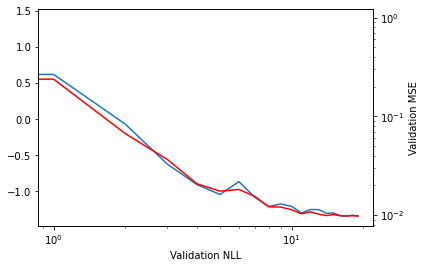

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

f, ax = plt.subplots()
ax.plot(nll_history)
ax.set_xlabel('Validation NLL')

ax2 = ax.twinx()
ax2.loglog(mse_history, color='r')
ax2.set_ylabel('Validation MSE')

# Generate New Data Points

In [20]:
def visualize_model(ax, object_ID = 10):
  df_objID0 = tmp[tmp.ID == object_ID]

  times, count = np.unique(df_objID0.Time,return_counts=True)
  time_ptr     = torch.from_numpy(np.concatenate([[0], count.cumsum()])).to(device)
  times        = torch.from_numpy(times,).to(torch.float32).to(device)

  X = torch.from_numpy(df_objID0.loc[:,val_cols].values).to(device) .to(torch.float32)
  M = torch.from_numpy(df_objID0.loc[:,[f"Mask_{i+1}" for i in range(5)]].values).to(device)
  obs_idx = torch.zeros((X.shape[0]), dtype=torch.long).to(device)

  cov = torch.from_numpy(tmp_cov[tmp_cov.index == object_ID].values)
  cov     = cov.to(torch.float32).to(device)

  hT, loss, _, t_vec, p_vec, h_vec, _, _  = model(times, time_ptr, X, M, obs_idx, delta_t=0.01, T=200.0, cov=cov, return_path=True)

  mean_pred, var_pred = torch.chunk(torch.squeeze(p_vec.detach(), 1), 2, dim=-1)
  t_pred              = t_vec
  sigma        = torch.exp(0.5 * var_pred)


  color_cyc = plt.rcParams['axes.prop_cycle'].by_key()['color']

  up_max   = 0
  down_max = 0
  for i in range(5):
    # ax.scatter(t_pred, mean_pred[:,i].cpu().numpy()+i)
    down = (mean_pred[:,i] - 1.96 * sigma[:,i]).cpu().numpy()+ i*0.5
    up   = (mean_pred[:,i] + 1.96 * sigma[:,i]).cpu().numpy()+ i*0.5
    ax.fill_between(t_pred.astype(float), down, up, alpha=0.3, color = color_cyc[i])

    flux = df_objID0[f"Value_{i+1}"]
    t    = df_objID0.Time
    ax.scatter(t[flux<1e4], flux[flux<1e4] + i*0.5, s = 10, color = color_cyc[i])

  up_max   = mean_pred.cpu().numpy().max()
  down_min = mean_pred.cpu().numpy().min()

  ax.set_ylim(down_min-0.5, up_max+5*0.5)

In [21]:
import pandas as pd
tmp = pd.read_csv(time_series_file)
tmp_cov = pd.read_csv(cov_file).set_index('ID')
val_cols = [f"Value_{i+1}" for i in range(5)]

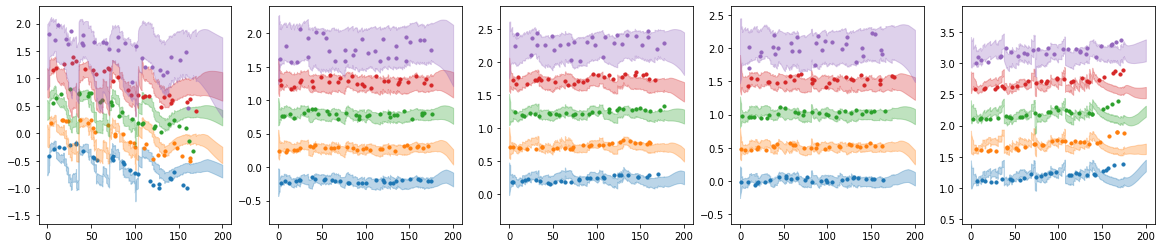

In [22]:
f, ax = plt.subplots(1, 5, sharex=True, figsize=(20,4))
ax_flat = ax.flat

count = 0
for i in np.random.randint(0, 10000, 5):
  visualize_model(ax = ax_flat[count], object_ID=i)
  count += 1